In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn

In [2]:
X = np.arange(-10,10,0.1)
X.shape

(200,)

In [3]:
## Code taken from http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
rolling_window(X[:5], 2)

array([[-10. ,  -9.9],
       [ -9.9,  -9.8],
       [ -9.8,  -9.7],
       [ -9.7,  -9.6]])

In [5]:
X = np.arange(-10,10,0.1)
X = np.cos(np.mean(rolling_window(X, 5), -1))
#X = X[:-5+1]
print(X.shape)

(196,)


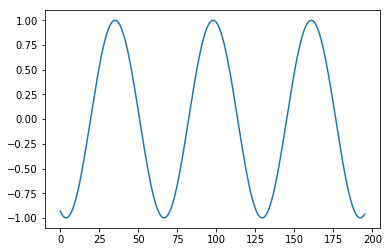

In [6]:
plt.plot(X)

## Implementation from Pytorch tutorial

In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = nn.Linear(input_size+hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x, h):
        inp = torch.cat((x,h), 1)
        hidden = self.tanh(self.i2h(inp))
        output = self.h2o(inp)
        return hidden, output
    
    
    def get_output(self, X):
        time_steps = X.size(0)
        batch_size = X.size(1)
        hidden = Variable(torch.zeros(batch_size, self.hidden_size))
        if torch.cuda.is_available() and X.is_cuda:
            hidden = hidden.cuda()
        outputs = []
        hiddens = []
        for t in range(time_steps):
            hidden, output = self.forward(X[t], hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(hiddens, 1), torch.cat(outputs, 1)
    
## Helper functions

def get_variable_from_np(X):
    return Variable(torch.from_numpy(X)).float()


def get_training_data(X, batch_size=10, look_ahead=1):
    ## Lookahead will always be one as the prediction is for 1 step ahead
    inputs = []
    targets = []
    time_steps = X.shape[0]
    for i in range(0, time_steps-batch_size-look_ahead):
        inp = X[i:i+batch_size, np.newaxis, np.newaxis]
        inputs.append(get_variable_from_np(inp))
        target = X[i+look_ahead:i+batch_size+look_ahead, np.newaxis, np.newaxis]
        targets.append(get_variable_from_np(target))
        #print(inp.shape, target.shape)
    return torch.cat(inputs, 1), torch.cat(targets, 1)


In [24]:
print(torch.cat([get_variable_from_np(X[i:i+5, np.newaxis, np.newaxis]) for i in range(X.shape[0]-5-1)], 1).size())
print(torch.cat([get_variable_from_np(X[i:i+5, np.newaxis, np.newaxis]) for i in range(1, X.shape[0]-5)], 1).size())

torch.Size([5, 190, 1])
torch.Size([5, 190, 1])


In [25]:
inputs, targets = get_training_data(X, batch_size=5)
inputs.size(), targets.size()

(torch.Size([5, 190, 1]), torch.Size([5, 190, 1]))

In [26]:
inputs, targets = get_training_data(X, batch_size=3)
inputs.size(), targets.size()

(torch.Size([3, 192, 1]), torch.Size([3, 192, 1]))

In [27]:
rnn = RNN(30, 20, 1)

In [28]:
criterion = nn.MSELoss()
batch_size = 10
TIMESTEPS = 5

batch = Variable(torch.randn(batch_size, 30))
hidden = Variable(torch.randn(batch_size, 20))
target = Variable(torch.randn(batch_size, 1))

loss = 0
for t in range(TIMESTEPS):
    hidden, output = rnn(batch, hidden)
    loss += criterion(output, target)
    
loss.backward()    

In [29]:
rnn = RNN(30, 20, 1).cuda()

In [30]:
criterion = nn.MSELoss()
batch_size = 10
TIMESTEPS = 5

batch = Variable(torch.randn(batch_size, 30)).cuda()
hidden = Variable(torch.randn(batch_size, 20)).cuda()
target = Variable(torch.randn(batch_size, 1)).cuda()

loss = 0
for t in range(TIMESTEPS):
    hidden, output = rnn(batch, hidden)
    loss += criterion(output, target)
    
loss.backward()

### Run on own data

In [31]:
rnn = RNN(1,3,1).cuda()

In [32]:
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adadelta(rnn.parameters())

In [33]:
X[:, np.newaxis, np.newaxis].shape

(196, 1, 1)

In [34]:
batch = get_variable_from_np(X[:, np.newaxis, np.newaxis]).cuda()

In [35]:
batch.is_cuda

True

In [36]:
batch = get_variable_from_np(X[:, np.newaxis, np.newaxis]).cuda()
hiddens, outputs = rnn.get_output(batch)

In [37]:
outputs.size()

torch.Size([1, 196])

In [38]:
target = get_variable_from_np(X[np.newaxis, :])
target.size()

torch.Size([1, 196])

In [39]:
torch.cat([get_variable_from_np(X[i:i+10, np.newaxis, np.newaxis]) for i in range(5)], 1).size()

torch.Size([10, 5, 1])

In [40]:
torch.cat([get_variable_from_np(X[i:i+10, np.newaxis, np.newaxis]) for i in range(5)], 1).size()

torch.Size([10, 5, 1])

In [42]:
rnn = RNN(1,3,1)
if torch.cuda.is_available():
    rnn = rnn.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adadelta(rnn.parameters())

In [43]:
batch_size = 1
TIMESTEPS = X.shape[0]
epochs = 10000
print_every = 1000
inputs, targets = get_training_data(X, batch_size=100)
if torch.cuda.is_available() and rnn.is_cuda:
    inputs = inputs.cuda()
    targets = targets.cuda()
print(inputs.size(), targets.size())
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    hiddens, outputs = rnn.get_output(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])
    if (i+1) % print_every == 0:
        print("Loss at epoch [%s]: %.3f" % (i, loss.data[0]))

AttributeError: 'RNN' object has no attribute 'is_cuda'

In [142]:
inputs, targets = get_training_data(X, batch_size=5)

In [143]:
inputs.size()

torch.Size([5, 190, 1])

In [144]:
inputs = inputs.cuda()

In [145]:
torch.cuda.is_available()

True

In [133]:
outputs[:, 0].size()

torch.Size([190])

In [134]:
X.shape, outputs[:, 0].data.numpy().flatten().shape

((196,), (190,))

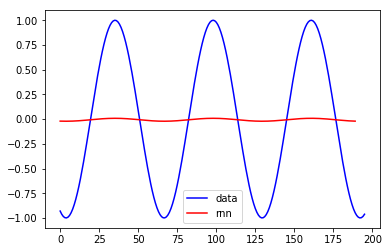

In [135]:
plt.plot(X, '-b', label='data')
plt.plot(outputs[:, 0].data.numpy().flatten(), '-r', label='rnn') # add some offset to view each curve
plt.legend()

# Try to use the LSTM cells and LSTM layer (Work in progress)



## Use LSTM cell

In [22]:
input_size, hidden_size, output_size = 1,3,1
lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
output_layer = nn.Linear(hidden_size, output_size)

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD([
    {"params": lstm.parameters()},
    {"params": output_layer.parameters()}
], lr=0.001, momentum=0.9)

## Use LSTM Layer

In [24]:
lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
output_layer = nn.Linear(hidden_size, output_size)

In [25]:
batch = get_variable_from_np(X[:, np.newaxis, np.newaxis])
batch.size()

torch.Size([196, 1, 1])

In [26]:
hidden = Variable(torch.zeros(1, batch.size(1), hidden_size))
cell_state = Variable(torch.zeros(1, batch.size(1), hidden_size))

In [27]:
hx = (hidden, cell_state)
output, (h_n, c_n) = lstm.forward(batch, hx)

In [28]:
output.size()

torch.Size([196, 1, 3])

In [29]:
out = output_layer.forward(output[0])
out

Variable containing:
-0.1082
[torch.FloatTensor of size 1x1]

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD([
    {"params": lstm.parameters()},
    {"params": output_layer.parameters()}
], lr=0.001, momentum=0.9)

In [34]:
batch_size = 1
epochs = 10

inputs, targets = get_training_data(X, max_steps=1)

for i in range(epochs):
    loss = 0
    optimizer.zero_grad()
    hidden = Variable(torch.zeros(1, inputs.size(1), hidden_size))
    cell_state = Variable(torch.zeros(1, inputs.size(1), hidden_size))
    hx = (hidden, cell_state)
    output, (h_n, c_n) = lstm.forward(inputs, hx)
    losses = []
    for j in range(output.size()[0]):
        out = output_layer.forward(output[j])
        losses.append((out - targets[j])**2)
        #loss += criterion(out, target[i])
    loss = torch.mean(torch.cat(losses, 1))
    loss.backward()
    optimizer.step()
    print("Loss at epoch [%s]: %.3f" % (i, loss.squeeze().data[0]))

Loss at epoch [0]: 0.810
Loss at epoch [1]: 0.808
Loss at epoch [2]: 0.804
Loss at epoch [3]: 0.801
Loss at epoch [4]: 0.797
Loss at epoch [5]: 0.792
Loss at epoch [6]: 0.787
Loss at epoch [7]: 0.782
Loss at epoch [8]: 0.777
Loss at epoch [9]: 0.771


In [35]:
output.size()

torch.Size([1, 195, 3])

In [37]:
out.size()

torch.Size([195, 1])

In [47]:
targets.size()

torch.Size([1, 195, 1])

In [42]:
y_pred = []
for i in range(output.size()[1]):
        out = output_layer.forward(output[i])
        y_pred.append(out.squeeze().data[0])
y_pred = np.array(y_pred)

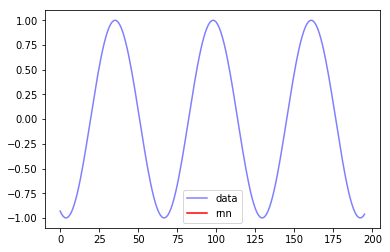

In [45]:
plt.plot(X, '-b', alpha=0.5, label='data')
plt.plot(y_pred + 0.1, '-r', label='rnn')
plt.legend()

In [46]:
y_pred

array([-0.34993339])